# El problema

Vamos a utilizar para ello el IRIS DataSet pero considerando únicamente dos características (nos facilitará la visualización de los resultados)




# 0. Carga de Datos

En este caso los datos nos la facilita la propia API de scikit-learn



In [2]:
# import some data to play with
from sklearn import datasets
iris = datasets.load_iris()

# we only take the first two features.
# We could avoid this ugly # slicing by using a two-dim dataset
X = iris.data
y = iris.target


Posteriomente lo cargamos en un DataFrame de Pandas con el nombre de *df_iris*

In [3]:
# 0. load data in DataFrame
import numpy as np
import pandas as pd
df_iris = pd.DataFrame(data= np.c_[iris['data'], iris['target']],
                     columns= iris['feature_names'] + ['target'])

df_iris.target = df_iris.target.astype(int)


df_iris.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [4]:
df_iris['target'].unique()

array([0, 1, 2])

Posteriormente seleccionamos las variables con las que trabajar. 

Es muy importante seleccionar las características cuando se va a resolver un problema mediante kNN ya que muchas variables pueden distorsionar el resultado del algoritmo que está basado en la distancia. 

Para realizar esta selección vamos a utilizar la correlación entre cada una de las características y la variable a predecir.



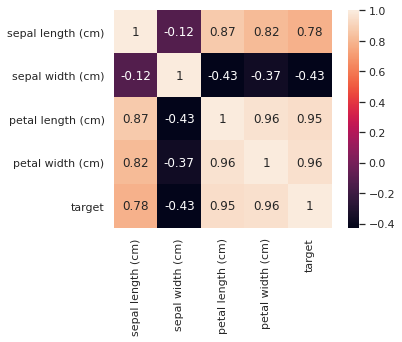

In [5]:
import seaborn as sns

sns.set()
sns.heatmap(df_iris.corr(), square=True, annot=True)

Existen variables muy correlacionadas entre si que nos pueden dificultar el trabajo por lo que podríamos eliminar alguna de ellas. 



Además vamos a dividir el conjunto de datos en train y test en un porcentaje de 2/3 vs 1/3

In [6]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df_iris[['petal length (cm)','petal width (cm)', 'target']], test_size=0.33)
train.reset_index(inplace = True)
test.reset_index(inplace = True)


#1. Parametrización

Existen diferentes parámetros para método basado en los vecinos más cercanos utilizando scikit-learn



*   **KNeighbors/Radius**: KNeihgbors está basado en el estudio de los k vecinos más cercanos para cada punto, mientras que RadiusNeighboors están basados en un conjunto de vecinos que están dentro de un radio. **Nuestra elección es la primera**, la segunda sería útil cuando los datos no estuvieran muestreados de forma uniforme.
* **K/Radio**
    * k: Un número k mayor suprime el efecto del ruido pero hace a los límites de clasificación más distintos.
    * Radios, un radio fijo es muy adecuado cuando los datos están muy dispersos (sparse neighbours)
*   **Pesos** : dos posibles valores, "uniform" cada vecino tiene el mismo peso, "distance" se asigna un peso a cada vecino proporcional a la distancia que esté del elemento referencia. También se puede definir una función por parte del usuario

Nuestra elección KNeighbors y k y pesos se van a parametrizar para ello se ejecutará [validación cruzada]([https://es.wikipedia.org/wiki/Validaci%C3%B3n_cruzada) y como medida de éxito vamos a utilizar el Accuracy


Max Value uniform : 1.0 (1)
Max Value distance : 1.0 (1)


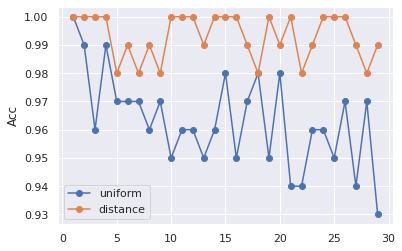

In [7]:
from sklearn import neighbors
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import numpy as np

cv = KFold(n_splits = 5, shuffle = True) # shuffle = False si hay dimensión temporal 


for i, weights in enumerate(['uniform', 'distance']):
   total_scores = []
   for n_neighbors in range(1,30):
       fold_accuracy = []
       knn = neighbors.KNeighborsClassifier(n_neighbors, weights=weights)
       for train_fold, test_fold in cv.split(train):
          # División train test aleatoria
          f_train = train.loc[train_fold]
          f_test = train.loc[test_fold]
          # entrenamiento y ejecución del modelo
          knn.fit( X = f_train.drop(['target'], axis=1), 
                               y = f_train['target'])
          y_pred = knn.predict(X = f_test.drop(['target'], axis = 1))
          # evaluación del modelo
          acc = accuracy_score(f_test['target'], y_pred)
          fold_accuracy.append(acc)
       total_scores.append(sum(fold_accuracy)/len(fold_accuracy))
   
   plt.plot(range(1,len(total_scores)+1), total_scores, 
             marker='o', label=weights)
   print ('Max Value ' +  weights + " : " +  str(max(total_scores)) +" (" + str(np.argmax(total_scores) + 1) + ")")
   plt.ylabel('Acc')      
    

plt.legend()
plt.show() 



# 2. Construcción y ejecución del modelo 



Una vez que hemos identificado la mejor parametrización vamos a pasar a hacer una ejecución del modelo y vamos graficar sus resultados.

Recordamos que al final del paso 1 hemos dividido en entrenamiento/tuneado y test

Posteriormente, vamos a ejecutar el modelo con la mejor parametrización que hayamos obtenido anteriormente 

In [15]:
# constructor
n_neighbors = 15
weights = 'uniform'
knn = neighbors.KNeighborsClassifier(n_neighbors= n_neighbors, weights=weights) 
# fit and predict
knn.fit(X = train[['petal length (cm)','petal width (cm)']], y = train['target'])
y_pred = knn.predict(X = test[['petal length (cm)','petal width (cm)']])
acc = accuracy_score(test['target'], y_pred)
print ('Acc', acc)



Acc 0.98


Graficamos la solución mediante los diagramas de Voronoi

In [10]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])
h = .05  # step size in the mesh


X = train[['petal length (cm)','petal width (cm)']].values
y = train['target'].values



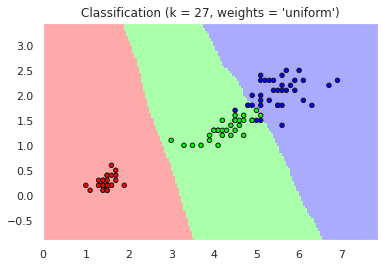

In [11]:

# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                       np.arange(y_min, y_max, h))
Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure()
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

# Plot also the training points
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold,
             edgecolor='k', s=20)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title("Classification (k = %i, weights = '%s')"
              % (n_neighbors, weights))

plt.show()
                         

Y finalmente visualizamos la Matriz de Confusión

In [12]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Confusion matrix, without normalization
[[17  0  0]
 [ 0 18  0]
 [ 0  1 14]]


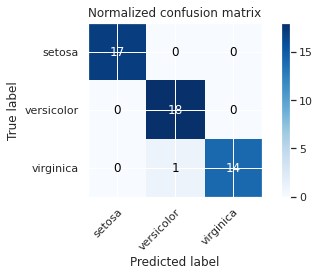

In [13]:
plot_confusion_matrix(test['target'], y_pred, classes=iris.target_names, normalize=False,
                      title='Normalized confusion matrix')
  